# Film recommendation engine based on my history list from Trakt.tv

> This notebook aims at building a recommendation engine from the content of my history list that contains around 1000 movies.

Recommendation engines are of three kinds :
* **popularity-based** : the most simple be also the most impersonal
* **content-based** : the recommendations are based on the description of the products
* **collaborative filtering** : records from various users provide recommendations based on user similarities

Now, I only will focus on the content and popularity of the films, thus collaborative filtering is excluded.

In [199]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

from wordcloud import WordCloud

import pandas as pd
import numpy as np

from collections import Counter
import requests
import json

from backports import configparser

config = configparser.ConfigParser()
config.read('config.ini')

CLIENT_ID = config.get('TRAKT','CLIENT_ID')
CLIENT_SECRET = config.get('TRAKT','CLIENT_SECRET')
OAUTH_TOKEN = config.get('TRAKT','OAUTH_TOKEN')

In [200]:
headers = {
  'Content-Type': 'application/json',
  'trakt-api-version': '2',
  'trakt-api-key': CLIENT_ID
}

## Get Data

In [194]:
# user slug
user_id = 'synyss' 

# Get extended info
history = 'https://api.trakt.tv/users/{}/history/movies?limit=1000&extended=full'.format(user_id)
resp = requests.get(history, headers=headers)

response_body = resp.json()
len(response_body)
# print(response_body)
# for pretty json print, uncomment :
print(json.dumps(response_body[0], indent=2))

{
  "id": 5746549317,
  "watched_at": "2020-03-10T19:09:00.000Z",
  "action": "watch",
  "type": "movie",
  "movie": {
    "title": "Lost in Translation",
    "year": 2003,
    "ids": {
      "trakt": 118,
      "slug": "lost-in-translation-2003",
      "imdb": "tt0335266",
      "tmdb": 153
    },
    "tagline": "Everyone wants to be found.",
    "overview": "Two lost souls visiting Tokyo -- the young, neglected wife of a photographer and a washed-up movie star shooting a TV commercial -- find an odd solace and pensive freedom to be real in each other's company, away from their lives in America.",
    "released": "2003-09-18",
    "runtime": 102,
    "country": "us",
    "trailer": "http://youtube.com/watch?v=1s4YQqnbnM8",
    "homepage": null,
    "status": "released",
    "rating": 7.68724,
    "votes": 7194,
    "comment_count": 30,
    "updated_at": "2020-03-02T08:20:46.000Z",
    "language": "en",
    "available_translations": [
      "bg",
      "cs",
      "da",
      "de",
   

In [4]:
df = pd.DataFrame()

for data in response_body:
    df = df.append({
            'title' : data['movie']['title'],
            'year' : data['movie']['year'],
            'watched_at' : data['watched_at'],
            'ids' : data['movie']['ids'],
            'tagline' : data['movie']['tagline'],
            'overview' : data['movie']['overview'],
            'released' : data['movie']['released'],
            'duration' : data['movie']['runtime'],
            'country' : data['movie']['country'],
            'rating' : data['movie']['rating'],
            'votes' : data['movie']['votes'],
            'language' : data['movie']['language'],
            'genres' : data['movie']['genres'],
            'certification' : data['movie']['certification']
        }, ignore_index=True)
df.to_csv('movies_history.csv', index=False)

In [2]:
df = pd.read_csv('movies_history.csv')

In [3]:
df = df.drop_duplicates(subset='ids')

In [4]:
df.head()

,certification,country,duration,genres,ids,language,overview,rating,released,tagline,title,votes,watched_at,year
0,R,us,102.0,"['drama', 'romance', 'comedy']","{'trakt': 118, 'slug': 'lost-in-translation-20...",en,"Two lost souls visiting Tokyo -- the young, ne...",7.68716,2003-09-18,Everyone wants to be found.,Lost in Translation,7189.0,2020-03-10T19:09:00.000Z,2003.0
1,R,us,137.0,"['action', 'science-fiction', 'drama', 'superh...","{'trakt': 161972, 'slug': 'logan-2017', 'imdb'...",en,"In the near future, a weary Logan cares for an...",7.98986,2017-03-03,His time has come,Logan,54447.0,2020-03-09T20:25:00.000Z,2017.0
2,PG-13,us,106.0,"['action', 'adventure', 'comedy']","{'trakt': 4757, 'slug': 'charlie-s-angels-full...",en,The Angels are charged with finding a pair of ...,5.80007,2003-06-27,This summer the Angels are back.,Charlie's Angels: Full Throttle,2811.0,2020-03-08T20:08:21.000Z,2003.0
3,PG-13,us,98.0,"['action', 'adventure', 'comedy', 'crime', 'th...","{'trakt': 2541, 'slug': 'charlie-s-angels-2000...",en,"Three women, detectives with a mysterious boss...",6.12826,2000-11-02,Get Some Action,Charlie's Angels,4288.0,2020-03-08T20:08:12.000Z,2000.0
4,NaN,us,108.0,"['drama', 'romance']","{'trakt': 221327, 'slug': 'all-the-bright-plac...",en,Two teens facing personal struggles form a pow...,7.04950,2020-02-28,Live life at full brightness,All the Bright Places,404.0,2020-03-08T19:59:00.000Z,2020.0


In [5]:
import ast # because of string representation of list

def listToString(s):
    '''for convenient print of genre'''
    str1 = "|"
    return (str1.join(s))

df['genres'] =  df['genres'].apply(lambda x : listToString(ast.literal_eval(x)))

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 906 entries, 0 to 918
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   certification  809 non-null    object 
 1   country        896 non-null    object 
 2   duration       905 non-null    float64
 3   genres         906 non-null    object 
 4   ids            906 non-null    object 
 5   language       905 non-null    object 
 6   overview       906 non-null    object 
 7   rating         906 non-null    float64
 8   released       904 non-null    object 
 9   tagline        791 non-null    object 
 10  title          906 non-null    object 
 11  votes          906 non-null    float64
 12  watched_at     906 non-null    object 
 13  year           904 non-null    float64
dtypes: float64(4), object(10)
memory usage: 106.2+ KB


In [7]:
df[df['year'].isnull()]

,certification,country,duration,genres,ids,language,overview,rating,released,tagline,title,votes,watched_at,year
378,NaN,us,46.0,documentary,"{'trakt': 394186, 'slug': 'inside-medical-mari...",en,"In Northern California's Emerald Triangle, mor...",9.00000,NaN,NaN,Inside: Medical Marijuana,1.0,2019-08-27T18:36:11.000Z,NaN
666,NaN,NaN,0.0,,"{'trakt': 228037, 'slug': 'dragon-ball-super',...",ja,"With Majin Boo defeated, peace returns to Eart...",8.08871,NaN,Doragon Bōru Sūpā,Dragon Ball Super,124.0,2018-11-12T19:55:32.000Z,NaN


In [8]:
# drop dragon-ball-super and 2011 for inside-medical-marijuana

df.drop([666], inplace=True)

df.at[378, 'year'] = 2011

In [9]:
df = df.astype({'year': int})

In [10]:
df.describe()

,duration,rating,votes,year
count,904.000000,905.000000,905.000000,905.000000
mean,110.085177,7.034109,10175.738122,2008.075138
std,25.157894,0.836851,10982.853958,8.847459
min,0.000000,3.116580,1.000000,1968.000000
25%,96.000000,6.538570,2213.000000,2004.000000
50%,109.000000,7.083860,6526.000000,2010.000000
75%,124.000000,7.625780,14467.000000,2015.000000
max,201.000000,9.500000,84750.000000,2020.000000


## Exploration

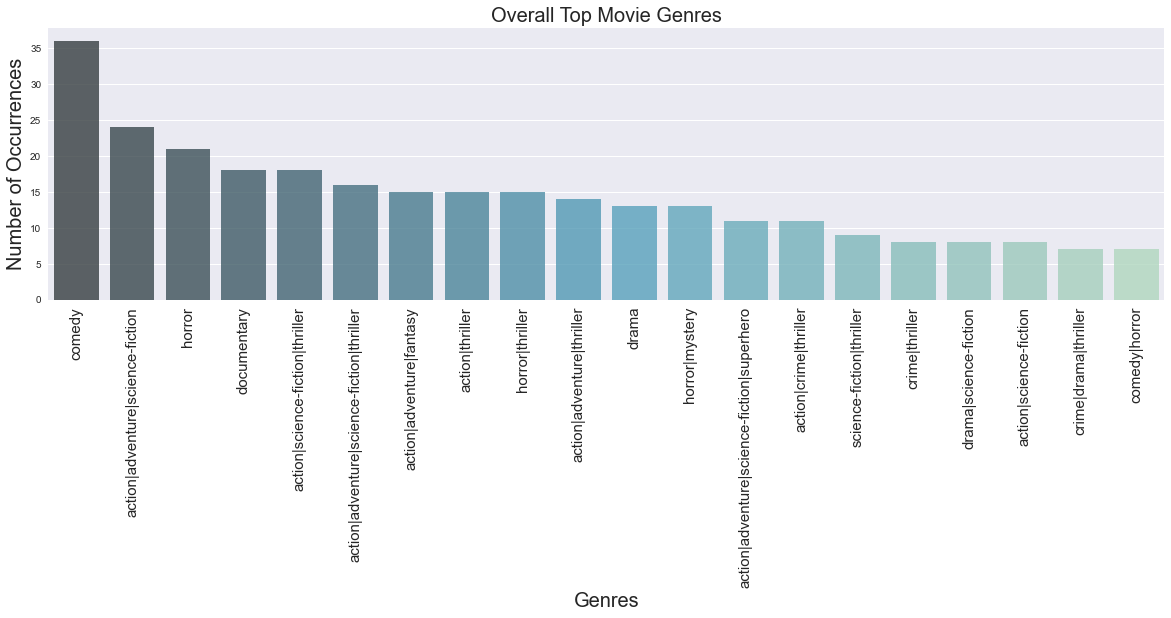

In [201]:
top_genres = df['genres'].value_counts(normalize=False)
top_genres = top_genres[:20,]

plt.figure(figsize=(20,5))

sns.barplot(top_genres.index, top_genres.values, alpha=0.8, palette='GnBu_d')

plt.title('Overall Top Movie Genres', fontsize=20)
plt.ylabel('Number of Occurrences', fontsize=20)
plt.xlabel('Genres', fontsize=20)
plt.xticks(rotation=90, fontsize=15)
plt.show()

In [203]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):        
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue        
        for s in [s for s in liste_keywords if s in liste]: 
            if pd.notnull(s): keyword_count[s] += 1

    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [204]:
genre_labels = set()
for s in df['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

keyword_occurences, dum = count_word(df, 'genres', genre_labels)
keyword_occurences[:3]

[['action', 423], ['thriller', 327], ['science-fiction', 315]]

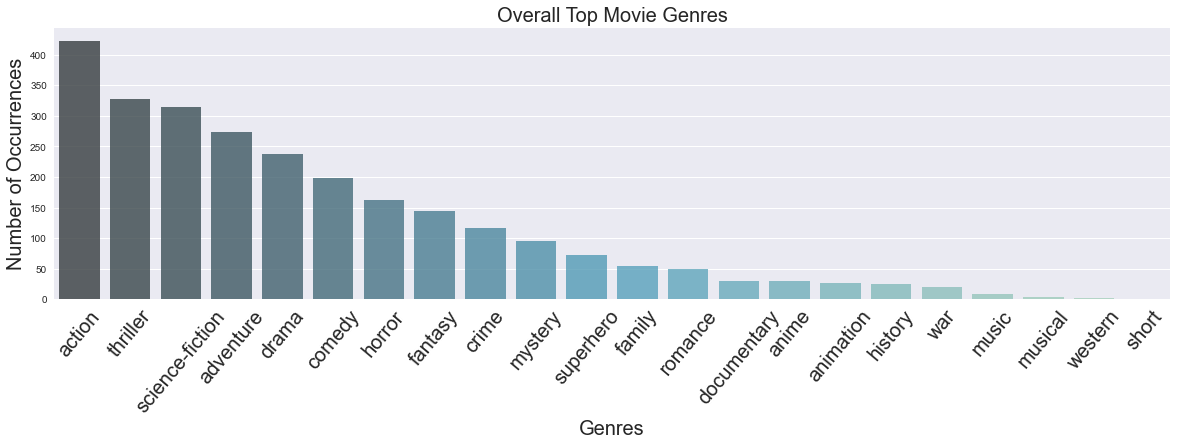

In [205]:
plt.figure(figsize=(20,5))
labels, ys = zip(*keyword_occurences)
xs = np.arange(len(labels)) 

sns.barplot(xs, ys, alpha=0.8, palette='GnBu_d')

plt.title('Overall Top Movie Genres', fontsize=20)
plt.ylabel('Number of Occurrences', fontsize=20)
plt.xlabel('Genres', fontsize=20)
plt.xticks(xs,labels, rotation=50, fontsize=20)
plt.show()

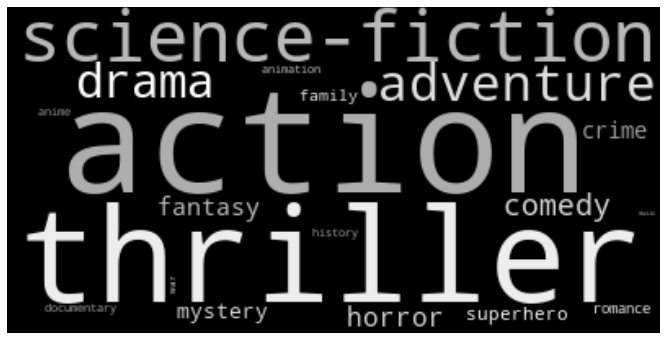

In [23]:
import random

def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

words = dict()
for s in keyword_occurences:
    words[s[0]] = s[1]

f, ax = plt.subplots(figsize=(20, 6))

wordcloud = WordCloud(color_func=grey_color_func)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [24]:
df['decade'] = df['year'].apply(lambda x:((x-1900)//10)*10)

# function that extract statistical parameters from a grouby objet:
def get_stats(gr):
    return {'min':gr.min(),'max':gr.max(),'count': gr.count(),'mean':gr.mean()}

# Creation of a dataframe with statitical infos on each decade:
test = df['year'].groupby(df['decade']).apply(get_stats).unstack()

In [25]:
test

,min,max,count,mean
decade,,,,
60,1968.0,1968.0,2.0,1968.000000
70,1972.0,1979.0,10.0,1976.600000
80,1980.0,1989.0,28.0,1985.500000
90,1990.0,1999.0,93.0,1995.548387
100,2000.0,2009.0,292.0,2005.150685
110,2010.0,2019.0,479.0,2014.409186
120,2020.0,2020.0,1.0,2020.000000


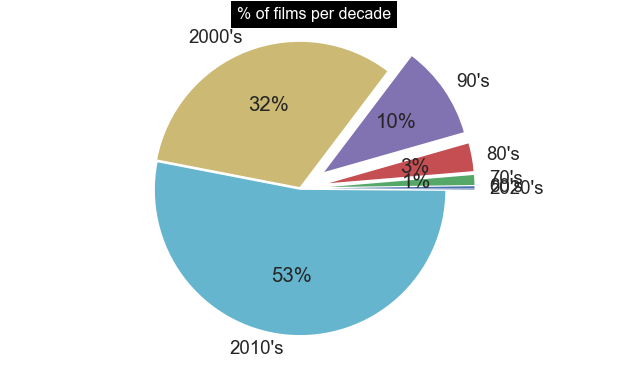

In [26]:
sns.set_context("poster", font_scale=0.85)

# funtion used to set the labels
def label(s):
    val = (1900 + s, s)[s < 100]
    chaine = '' if s < 50 else "{}'s".format(int(val))
    return chaine

f, ax = plt.subplots(figsize=(11, 6))

labels = [label(s) for s in  test.index]
sizes  = test['count'].values
explode = [0.2 if sizes[i] < 100 else 0.01 for i in range(7)]

ax.pie(sizes, explode = explode, labels=labels,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow=False, startangle=0)
ax.axis('equal')
ax.set_title('% of films per decade',
             bbox={'facecolor':'k', 'pad':5}, color='w', fontsize=16);

df.drop('decade', axis=1, inplace = True)

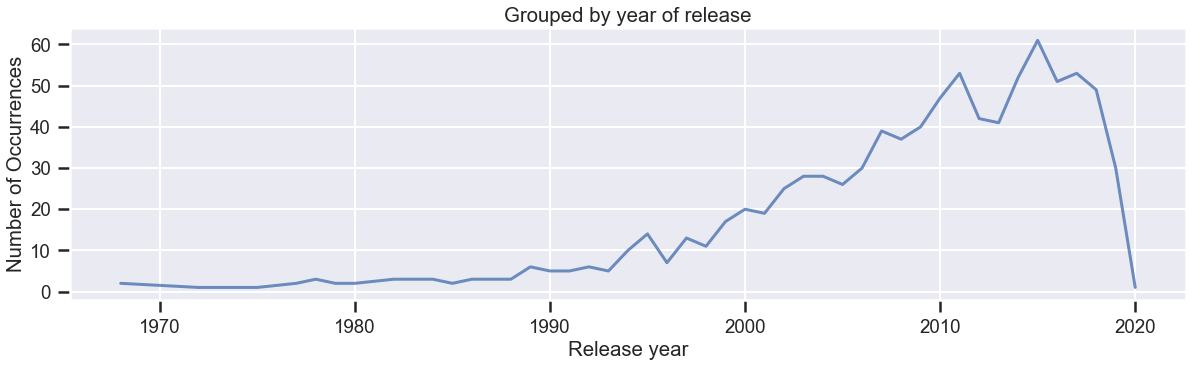

In [27]:
data = df['year'].value_counts().sort_index()

plt.figure(figsize=(20,5))

sns.lineplot(data.index, data.values, alpha=0.8, palette='GnBu_d')

plt.title('Grouped by year of release')
plt.ylabel('Number of Occurrences')
plt.xlabel('Release year')
plt.show()

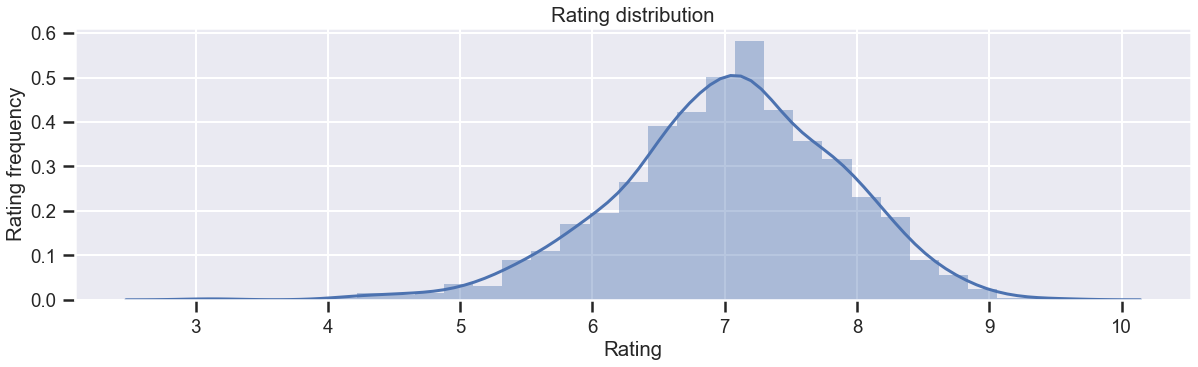

In [28]:
data = df['rating']

plt.figure(figsize=(20,5))

sns.distplot(data)

plt.title('Rating distribution')
plt.ylabel('Rating frequency')
plt.xlabel('Rating')
plt.show()

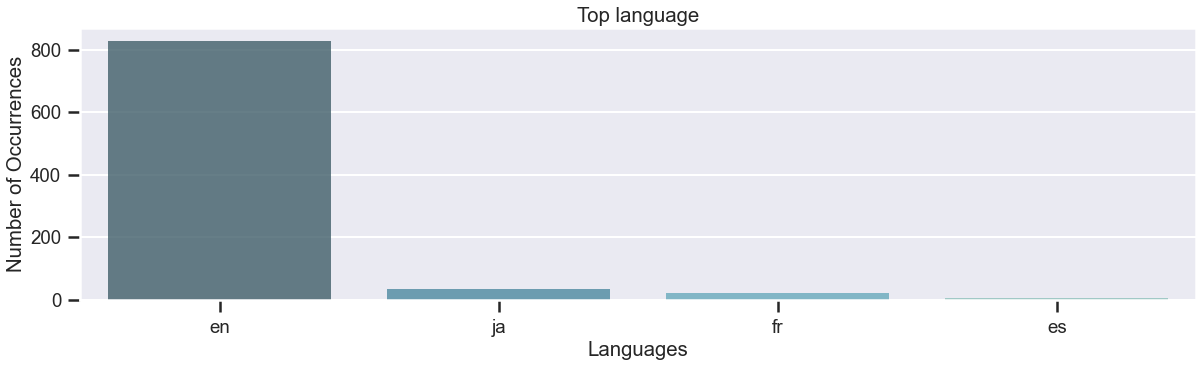

In [29]:
data = df['language'].value_counts(normalize=False)
data = data[:4,]

plt.figure(figsize=(20,5))

g = sns.barplot(data.index, data.values, alpha=0.8, palette='GnBu_d')

plt.title('Top language')
plt.ylabel('Number of Occurrences')
plt.xlabel('Languages')
plt.xticks()
plt.show()

In [182]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    
    for s in liste: keyword_count[s] = 0
        
    for liste_keywords in df[ref_col].str.split('|'):        
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue        
        for s in [s for s in liste_keywords if s in liste]: 
            if pd.notnull(s): keyword_count[s] += 1

    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_count

In [183]:
def most_common_inclusive(freq_dict):
    # find the nth most common value
    nth_most_common = sorted(freq_dict.values(), reverse=True)[0]
    return { k: v for k, v in freq_dict.items() if v >= nth_most_common }

genre_labels = set()
for s in df['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

keyword_occurences = count_word(df, 'genres', genre_labels)

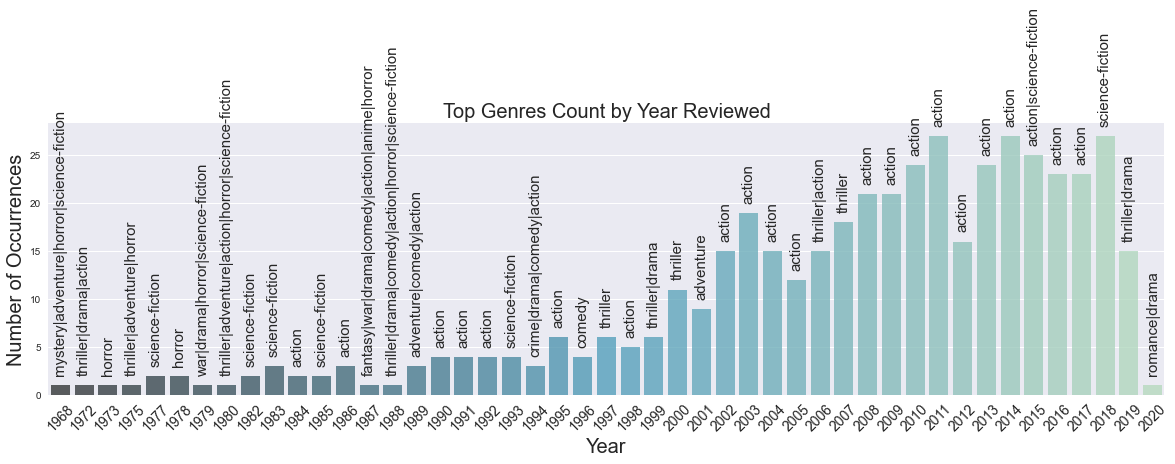

In [186]:
reviews_by_genres = df.groupby(['year']).apply(lambda x : count_word(x, 'genres', genre_labels)).reset_index()
reviews_by_genres[0] = reviews_by_genres[0].apply(most_common_inclusive)
reviews_by_genres['genres'] = reviews_by_genres[0].apply(lambda dict1 : '|'.join(x for x in dict1.keys()))
reviews_by_genres['counts'] = reviews_by_genres[0].apply(lambda dict1: list(dict1.values())[0])
reviews_by_genres.drop([0], axis=1, inplace=True)

plt.figure(figsize=(20,5))

g = sns.barplot(reviews_by_genres['year'], reviews_by_genres['counts'], alpha=0.8, palette='GnBu_d')

plt.title('Top Genres Count by Year Reviewed', fontsize=20)
plt.ylabel('Number of Occurrences', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.xticks(rotation=45, fontsize=14)


for index, row in reviews_by_genres.iterrows():
    g.text(row.name, row.counts + 1, row.genres, ha="center", rotation=90, 
           verticalalignment='bottom', fontsize=15)

plt.show()

In [225]:
df['description'] = df['tagline'] + ' ' + df['overview']
df['description'] = df['description'].fillna(' ')
df['description']

0      Everyone wants to be found. Two lost souls vis...
1      His time has come In the near future, a weary ...
2      This summer the Angels are back. The Angels ar...
3      Get Some Action Three women, detectives with a...
4      Live life at full brightness Two teens facing ...
                             ...                        
914    Welcome to the Real World. Set in the 22nd cen...
915    Life is like a box of chocolates...you never k...
916    Just because you are a character doesn't mean ...
917    Why So Serious? Batman raises the stakes in hi...
918    One giant leap into the unknown A look at the ...
Name: description, Length: 905, dtype: object

In [226]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 3),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(df['description'])

freqs = {word : tfidf_matrix.getcol(idx).sum() for word, idx in tf.vocabulary_.items()}


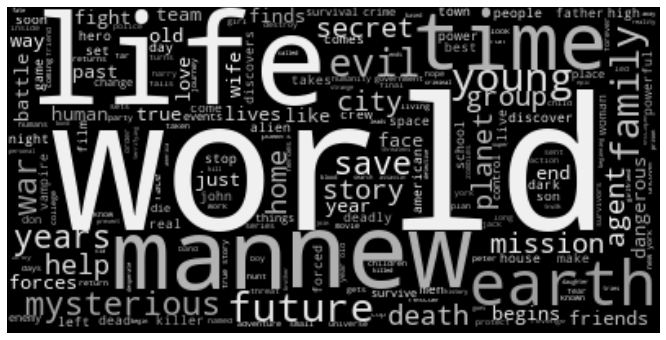

In [250]:
f, ax = plt.subplots(figsize=(20,6))

wordcloud = WordCloud(color_func=grey_color_func)
wordcloud.generate_from_frequencies(freqs)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Extended Info

Returns all `cast` and `crew` for a movie. Each `cast` member will have a `characters` array and a standard `person` object.

The `crew` object will be broken up into `production`, `art`, `crew`, `costume & make-up`, `directing`, `writing`, `sound`, `camera`, `visual effects`, `lighting`, and `editing` (if there are people for those crew positions). Each of those members will have a `jobs` array and a standard `person` object.


From the [Trakt API Documentation](https://trakt.docs.apiary.io/)

In [253]:
# get all people for a movie
movie = 'lost-in-translation-2003'
all_people = 'https://api.trakt.tv/movies/{}/people'.format(movie)
resp = requests.get(all_people, headers=headers)

response_body = resp.json()
# print(response_body)
# for pretty json print, uncomment :
print(json.dumps(response_body['cast'][:3], indent=2))

[
  {
    "character": "Bob Harris",
    "characters": [
      "Bob Harris"
    ],
    "person": {
      "name": "Bill Murray",
      "ids": {
        "trakt": 411482,
        "slug": "bill-murray",
        "imdb": "nm0000195",
        "tmdb": 1532,
        "tvrage": 11014
      }
    }
  },
  {
    "character": "Charlotte",
    "characters": [
      "Charlotte"
    ],
    "person": {
      "name": "Scarlett Johansson",
      "ids": {
        "trakt": 5656,
        "slug": "scarlett-johansson",
        "imdb": "nm0424060",
        "tmdb": 1245,
        "tvrage": 52154
      }
    }
  },
  {
    "character": "John",
    "characters": [
      "John"
    ],
    "person": {
      "name": "Giovanni Ribisi",
      "ids": {
        "trakt": 297479,
        "slug": "giovanni-ribisi",
        "imdb": "nm0000610",
        "tmdb": 1771,
        "tvrage": 20175
      }
    }
  }
]


In [256]:
print(json.dumps(response_body['crew'], indent=2))

{
  "production": [
    {
      "job": "Executive Producer",
      "jobs": [
        "Executive Producer"
      ],
      "person": {
        "name": "Fred Roos",
        "ids": {
          "trakt": 588,
          "slug": "fred-roos",
          "imdb": "nm0740407",
          "tmdb": 2871,
          "tvrage": 119066
        }
      }
    },
    {
      "job": "Producer",
      "jobs": [
        "Producer"
      ],
      "person": {
        "name": "Ross Katz",
        "ids": {
          "trakt": 1698,
          "slug": "ross-katz",
          "imdb": "nm0441839",
          "tmdb": 1777,
          "tvrage": null
        }
      }
    },
    {
      "job": "Producer",
      "jobs": [
        "Producer"
      ],
      "person": {
        "name": "Francis Ford Coppola",
        "ids": {
          "trakt": 5976,
          "slug": "francis-ford-coppola",
          "imdb": "nm0000338",
          "tmdb": 1776,
          "tvrage": 64559
        }
      }
    },
    {
      "job": "Associate Produc